## ECE 661 Project: Evaluation and Metrics

In [1]:
from pytorch_fid import fid_score
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

from gan.module.gd import Generator
from gan.model.utils import latent_interpolation
from gan.model.data import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
path_to_gan = "./weights/GAN/GAN_generator.pth"
path_to_wgan = "./weights/WGAN/WGAN_generator.pth"
path_to_wgan_gp = "./weights/WGAN-GP/WGAN-GP_generator.pth"

In [8]:
def load_generator(path):
    model = Generator(in_dim=100)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model


def generate_noise(batch_size, dim):
    return torch.randn(batch_size, dim)


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 64, 64)
    return x.cpu().numpy()


def plot_images(images):
    num_images = images.shape[0]
    rows = int(np.sqrt(num_images))
    cols = (num_images // rows) + (0 if num_images % rows == 0 else 1)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(np.transpose(images[i], (1, 2, 0)))  # convert from (C, H, W) to (H, W, C)
            ax.axis('off')
        else:
            ax.axis('off')
    plt.show()

## Plot WGAN-GP Samples

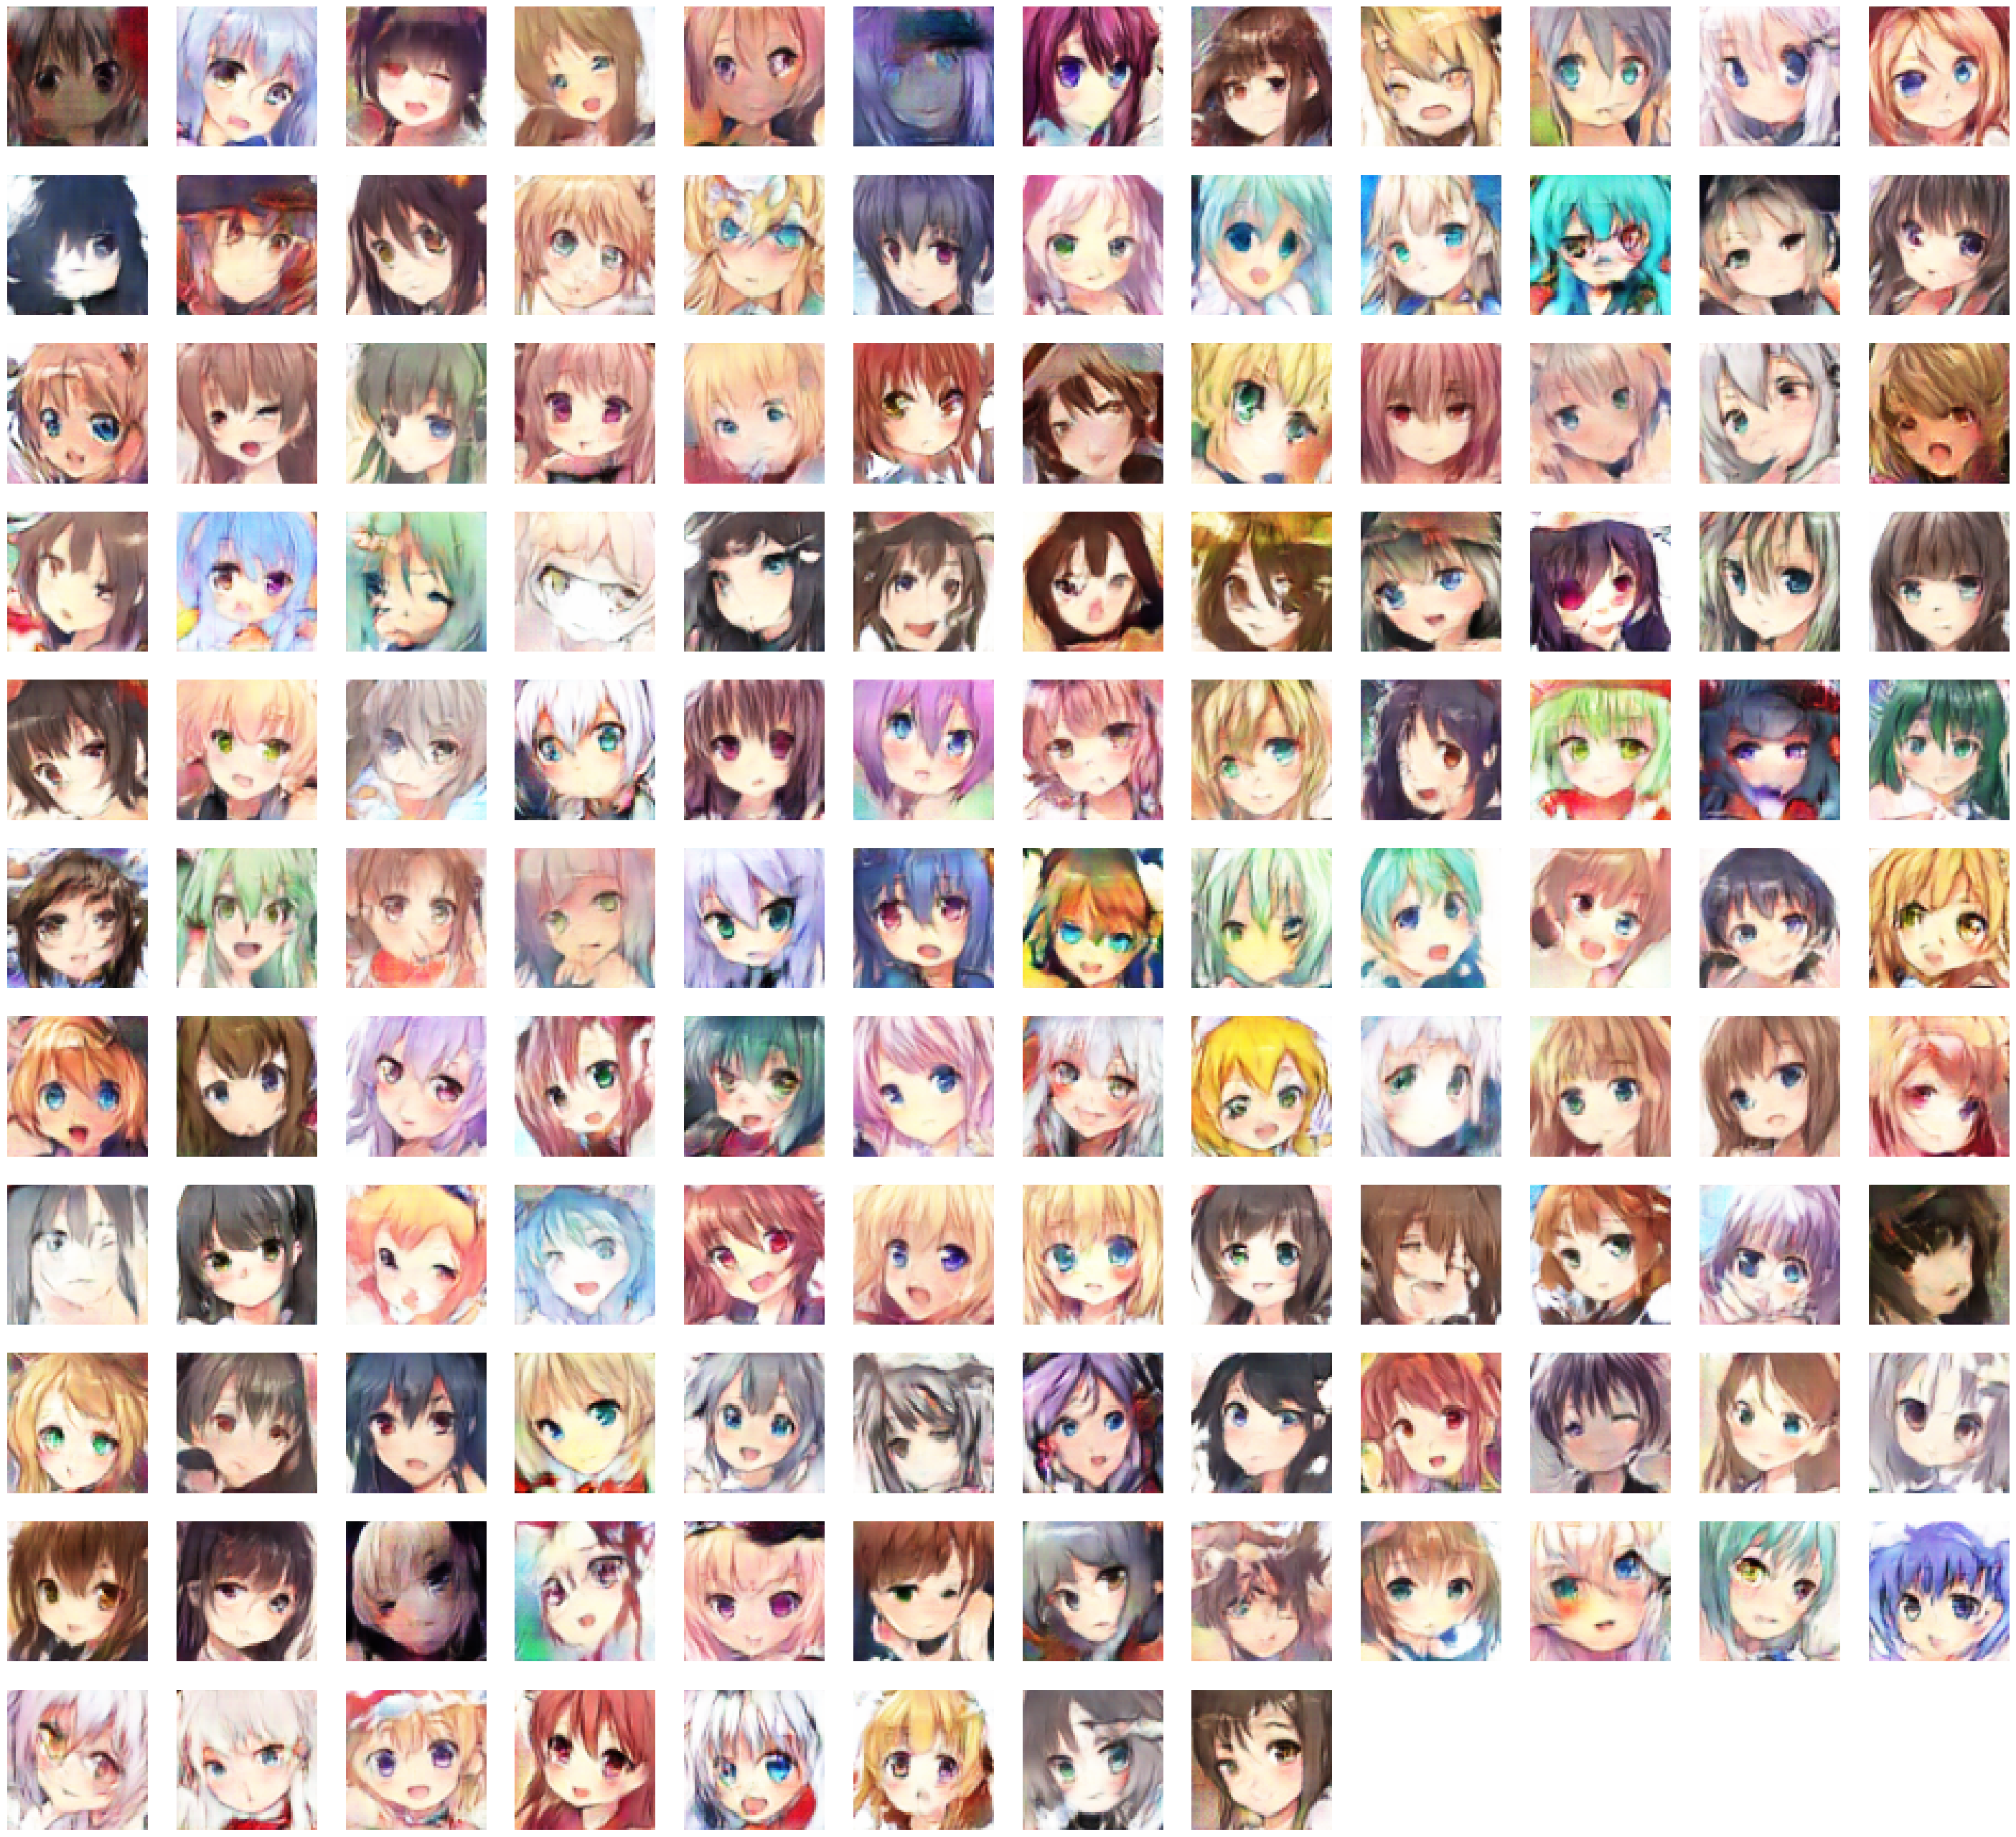

In [11]:
batch_size = 128
generator = load_generator(path_to_wgan_gp)
generator.eval()
z_sample = generate_noise(batch_size, 100)

with torch.no_grad():
    generated_images = generator(z_sample)

plot_images(to_img(generated_images))

## Latent Interpolation

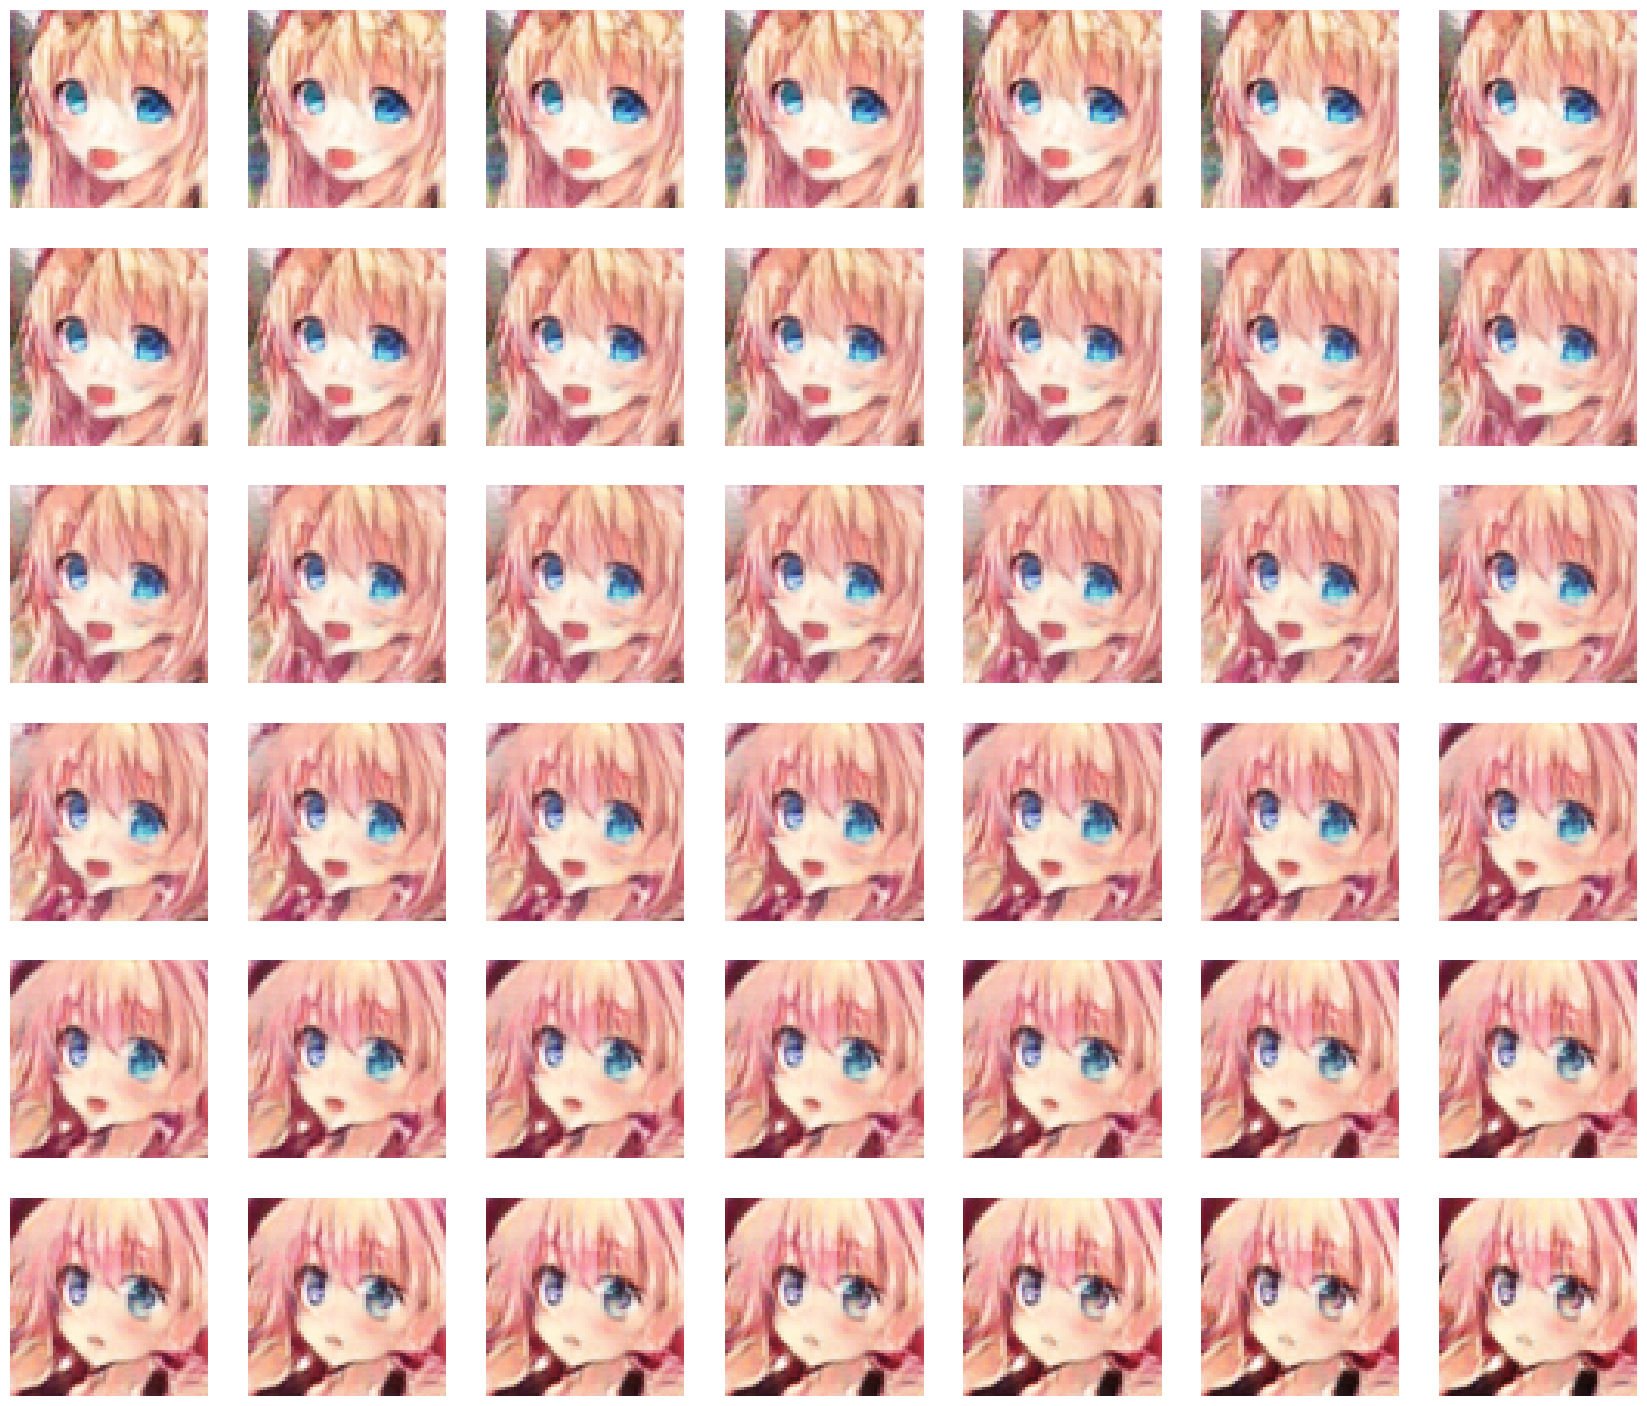

In [14]:
latent_dim = 100 # set this to input dim
num_points = 42
z_samples = latent_interpolation(num_points, latent_dim, device='cpu')

with torch.no_grad():
    images = []
    for z_sample in z_samples:
        z_sample_batched = z_sample.unsqueeze(0)
        image = generator(z_sample_batched)
        images.append(image)

images_tensor = torch.stack(images)
plot_images(to_img(images_tensor))

## Calculate the FID

In [6]:
def calculate_fid(generator, dataloader, device='cuda', num_images=1000, batch_size=64):
    generator.to(device)
    generator.eval()

    real_path = './real_images'
    fake_path = './fake_images'
    os.makedirs(real_path, exist_ok=True)
    os.makedirs(fake_path, exist_ok=True)

    # Generate and save real images
    real_count = 0
    for real_images in dataloader:
        for real_image in real_images:
            if real_count >= num_images:
                break
            real_image = (real_image + 1) / 2
            save_image(real_image, os.path.join(real_path, f'real_{real_count}.png'))
            real_count += 1
        if real_count >= num_images:
            break

    # Generate and save fake images
    fake_count = 0
    with torch.no_grad():
        while fake_count < num_images:
            z = torch.randn(batch_size, 100, device=device)
            fake_images = generator(z)
            for fake_image in fake_images:
                if fake_count >= num_images:
                    break
                fake_image = (fake_image + 1) / 2
                save_image(fake_image, os.path.join(fake_path, f'fake_{fake_count}.png'))
                fake_count += 1

    # Calculate FID score
    fid = fid_score.calculate_fid_given_paths([real_path, fake_path], batch_size, device, 2048)

    # Clean up directories
    for folder in [real_path, fake_path]:
        for filename in os.listdir(folder):
            os.remove(os.path.join(folder, filename))
        os.rmdir(folder)

    return fid

In [7]:
dataset = get_dataset("./data/faces")
fid_results = {}

for path_to_version in [path_to_gan, path_to_wgan, path_to_wgan_gp]:
    generator = load_generator(path_to_version)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
    fid_results[path_to_version] = calculate_fid(generator, dataloader, device='cuda')
    
print(fid_results)

100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


{'./weights/GAN/GAN_generator.pth': 127.89401075477812, './weights/WGAN/WGAN_generator.pth': 224.87442732349427, './weights/WGAN-GP/WGAN-GP_generator.pth': 95.70753008661362}
